# Apache Spark / PySpark

[Spark 3.3.x](https://spark.apache.org/docs/3.3.0/)  

Reference/API Links


*   [Apache Spark Quick Start](https://spark.apache.org/docs/3.3.0/quick-start.html)
*   [PySpark v3.3.0 API](https://spark.apache.org/docs/3.3.0/api/python/reference/index.html)
*    [RDD Programming Guide](https://spark.apache.org/docs/3.3.0/rdd-programming-guide.html)
*    [Spark SQL Programming Guide](https://spark.apache.org/docs/3.3.0/sql-programming-guide.html)









In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt update -qq
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 987.4/987.4 kB 20.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
59 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 59 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package libxtst6:amd64.
(Reading database

# 1. Introduction


We chose this data set just because basketball is an interesting topic with a surprisingly large amount of data available. We explored the play by play logs of NBA and WNBA regular season games. Overall, the project shows key differences between leagues and highlights major shifts in NBA style, such as increasing three-point shooting and changes in average shot distance.

# 2. Dataset


We used data that was collected and compiled by a user and presented on Kaggle. Each row corresponds to an event, and contains lots of information, including when the event happened, where it happened, what type of event happened, and a written description of the event. To reproduce results, all CSV files (NBA 2016–2024 and WNBA 2024) should be placed in the same working directory as the project notebook

# 3. Questions

How do the NBA and WNBA differ?

How has shooting and playstyle in the NBA changed over time?

# 4. Problem Decomposition

Since the data is very large, we treated it as if it could not run on one computer. So by using spark dataframe transformations, we could distribute across multiple machines and combine at the end to use pandas, matplotlib, and seaborn to graph and visualize the data, such as showing the field goal average.The data transformations, filtering, creating columns, grouping, and selections were done using Spark, and after the large data was summarized into smaller, more usable data, turned into a visualization using non-distributed methods.

# Imports




In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import *

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

spark = SparkSession.builder.appName("CSC369 Project").getOrCreate()


Set up and loading data


In [ ]:
df_wnba = (spark.read
           .option("header", "true")
           .csv("wnba_datanba_2024.csv"))

df_wnba.show()

df_nba = (spark.read
           .option("header", "true")
           .csv("datanba_2024.csv"))


+---+--------------------+-----+--------------------+----+----+----+----+----+----+-----+-----+-------+----------+-------+---+---+-------+----------+------+---+------+----------+
|evt|             wallclk|   cl|                  de|locX|locY|opt1|opt2|opt3|opt4|mtype|etype|   opid|       tid|    pid| hs| vs|   epid|     oftid|   ord|pts|PERIOD|   GAME_ID|
+---+--------------------+-----+--------------------+----+----+----+----+----+----+-----+-----+-------+----------+-------+---+---+-------+----------+------+---+------+----------+
|  2|2024-05-14T23:02:...|10:00|        Start Period|   0| -80|   0|   0|   0|   0|    0|   12|   NULL|         0|      0|  0|  0|   NULL|         0| 20000|  0|     1|1022400001|
|  4|2024-05-14T23:02:...|09:57|Jump Ball Jones v...|   0| -80|   0|   0|   0|   0|    0|   10|1631022|1611661313|1627673|  0|  0| 202664|1611661313| 60000|  0|     1|1022400001|
|  7|2024-05-14T23:02:...|09:56|[NYL] Vandersloot...| 115| 344|   0|   0|   0|   0|   45|    5|   NULL|16

# Differences between WNBA and NBA


Union both dataframes

In [ ]:
nba_df = df_nba.withColumn("league", lit("NBA"))
wnba_df = df_wnba.withColumn("league", lit("WNBA"))

combined_df = nba_df.unionByName(wnba_df)

combined_df.show(5)
combined_df.count()

+---+--------------------+-----+--------------------+----+----+----+----+----+----+-----+-----+-------+----------+-------+---+---+-------+----------+------+---+------+--------+------+
|evt|             wallclk|   cl|                  de|locX|locY|opt1|opt2|opt3|opt4|mtype|etype|   opid|       tid|    pid| hs| vs|   epid|     oftid|   ord|pts|PERIOD| GAME_ID|league|
+---+--------------------+-----+--------------------+----+----+----+----+----+----+-----+-----+-------+----------+-------+---+---+-------+----------+------+---+------+--------+------+
|  2|2024-11-13T00:10:...|12:00|        Start Period|   0| -80|   0|   0|   0|   0|    0|   12|   NULL|         0|      0|  0|  0|   NULL|         0| 20000|  0|     1|22400001|   NBA|
|  4|2024-11-13T00:10:...|11:58|Jump Ball Capela ...|   0| -80|   0|   0|   0|   0|    0|   10| 201143|1610612737| 203991|  0|  0|1630811|1610612737| 60000|  0|     1|22400001|   NBA|
|  7|2024-11-13T00:10:40Z|11:43|[ATL] Risacher 3p...|-168| 205|   3|   0|   0|  

684433

In [ ]:
fg = (combined_df
      .filter(col("etype").isin("1", "2"))
      .filter(col("opt1").isin("2", "3"))
      .withColumn("made", when(col("etype") == "1", 1).otherwise(0))
      .select("league", col("opt1").alias("Point Value"), "made")
      .groupBy("league", "Point Value")
      .agg(count("*").alias("Attempts"),
           sum("made").alias("Made"),
            (sum("made") / count("*") * 100).alias("FG Percentage"))
      .orderBy("Point Value"))

fg.show()

+------+-----------+--------+-----+------------------+
|league|Point Value|Attempts| Made|     FG Percentage|
+------+-----------+--------+-----+------------------+
|   NBA|          2|  127073|69262| 54.50567783872262|
|  WNBA|          2|   21798|10641|48.816405174786674|
|   NBA|          3|   92455|33304|  36.0218484668217|
|  WNBA|          3|   10962| 3707| 33.81682174785623|
+------+-----------+--------+-----+------------------+



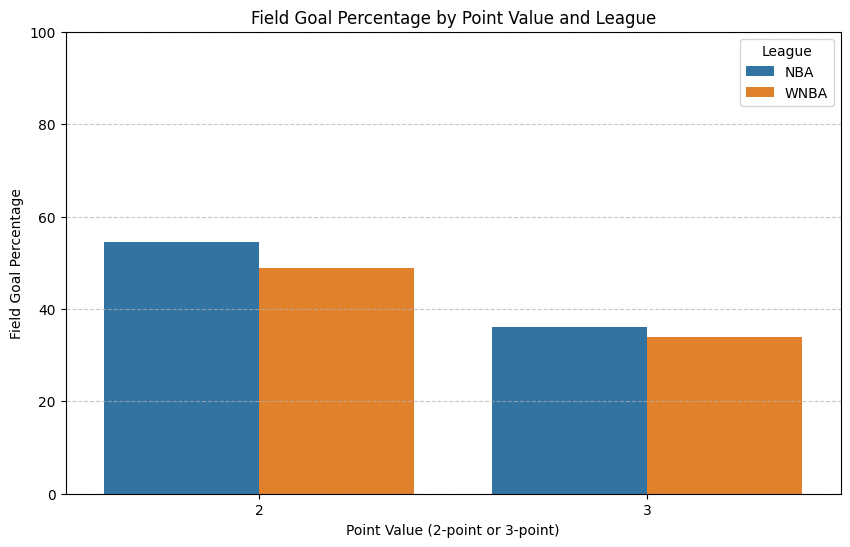

In [ ]:
fg_pd = fg.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=fg_pd,
            x='Point Value',
            y='FG Percentage',
            hue='league')
plt.title('Field Goal Percentage by Point Value and League')
plt.xlabel('Point Value (2-point or 3-point)')
plt.ylabel('Field Goal Percentage')
plt.ylim(0, 100)
plt.legend(title='League')
plt.grid(axis='y',
         linestyle='--',
         alpha=0.7)
plt.show()

In [ ]:
threes_per_game = (combined_df
                   .filter(col("opt1") == "3")
                   .withColumn("made", when(col("etype") == "1", 1).otherwise(0))
                   .groupBy("league")
                   .agg(
                       count("*").alias("Three Attempts"),
                       sum("made").alias("Threes Made"),
                       countDistinct("GAME_ID").alias("Total Games"))
                   .withColumn("Attempts per Game", col("Three Attempts") / col("Total Games"))
                   .withColumn("Made per Game", col("Threes Made") / col("Total Games")))

threes_per_game.show()

+------+--------------+-----------+-----------+-----------------+------------------+
|league|Three Attempts|Threes Made|Total Games|Attempts per Game|     Made per Game|
+------+--------------+-----------+-----------+-----------------+------------------+
|  WNBA|         10962|       3707|        240|           45.675|15.445833333333333|
|   NBA|         92455|      33304|       1230|75.16666666666667|27.076422764227644|
+------+--------------+-----------+-----------+-----------------+------------------+



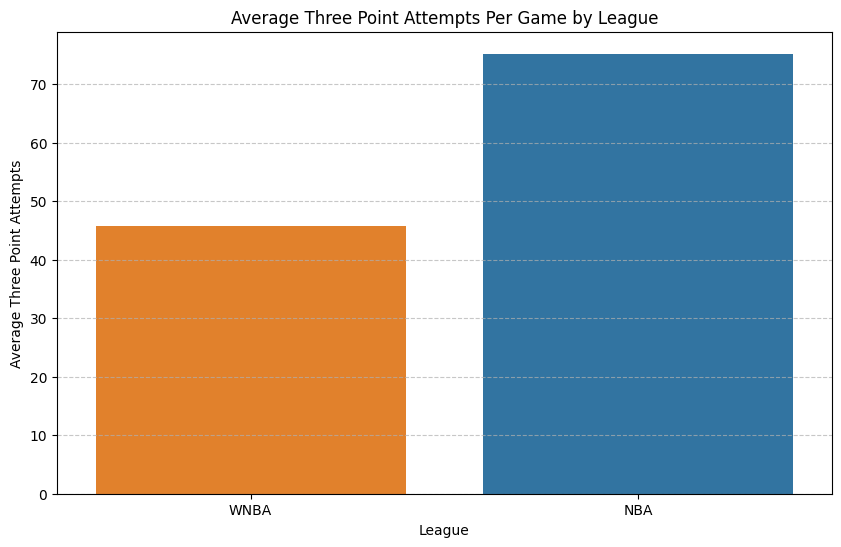

In [ ]:
threes_per_game_pd = threes_per_game.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=threes_per_game_pd,
            x='league',
            y='Attempts per Game',
            hue='league',
            palette={'NBA': '#1f77b4', 'WNBA': '#ff7f0e'})
plt.title('Average Three Point Attempts Per Game by League')
plt.xlabel('League')
plt.ylabel('Average Three Point Attempts')
plt.grid(axis='y',
         linestyle='--',
         alpha=0.7)
plt.show()

In [ ]:
ratio_df = (
    combined_df
    .filter(col("etype").isin("1", "2"))
    .filter(col("opt1").isin("2", "3"))
    .withColumn("made", when(col("etype") == "1", 1).otherwise(0))
    .withColumn("value", col("opt1").cast("int")))

ratio = (
    ratio_df.groupBy("league")
        .agg(
            count("*").alias("shots"),
            sum(when(col("value") == 2, 1)).alias("2PA"),
            sum(when(col("value") == 3, 1)).alias("3PA"),
            sum(when((col("value") == 2) & (col("made") == 1), 1)).alias("2PM"),
            sum(when((col("value") == 3) & (col("made") == 1), 1)).alias("3PM")
        )
        .withColumn("2P%", col("2PM") / col("2PA") * 100)
        .withColumn("3P%", col("3PM") / col("3PA") * 100)
        .withColumn("2P share", col("2PA") / col("shots") * 100)
        .withColumn("3P share", col("3PA") / col("shots") * 100)
        .select("league", "2P share", "3P share"))

ratio.show()


+------+------------------+-----------------+
|league|          2P share|         3P share|
+------+------------------+-----------------+
|   NBA|57.884643416785096| 42.1153565832149|
|  WNBA| 66.53846153846153|33.46153846153846|
+------+------------------+-----------------+



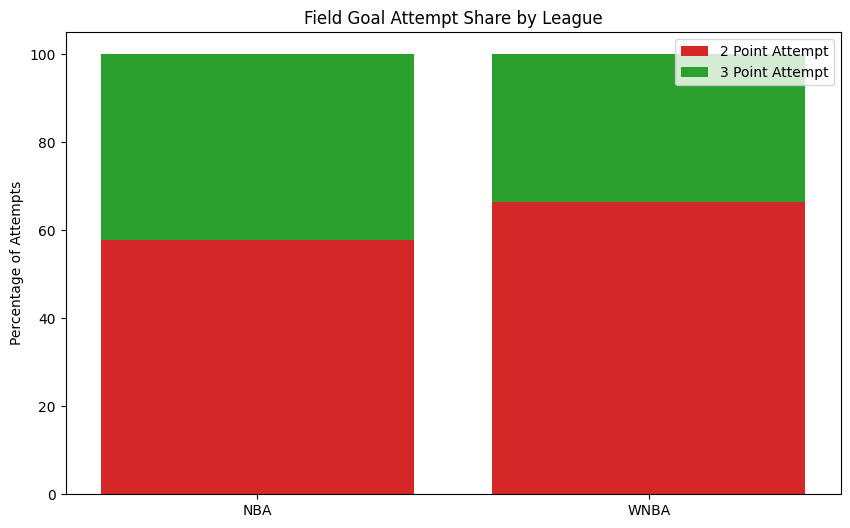

In [ ]:
ratio_pd = ratio.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(ratio_pd["league"],
        ratio_pd["2P share"],
        label="2 Point Attempt",
        color = "#d62728")
plt.bar(ratio_pd["league"],
        ratio_pd["3P share"],
        bottom=ratio_pd["2P share"],
        label="3 Point Attempt",
        color = '#2ca02c')
plt.ylabel("Percentage of Attempts")
plt.title("Field Goal Attempt Share by League")
plt.legend()

plt.show()

In [ ]:
games_per_league = (combined_df
                    .select("league", "GAME_ID")
                    .distinct()
                    .groupBy("league")
                    .agg(countDistinct("GAME_ID").alias("Total Games")))

fouls_with_rates = (combined_df
                    .filter(col("etype") == "6")
                    .withColumn(
                        "Foul Type",
                        when(col("opt1") == "0", "Personal Foul")
                        .when(col("opt1") == "1", "Shooting Foul")
                        .otherwise("Unknown"))
                    .groupBy("league", "Foul Type")
                    .agg(count("*").alias("Foul Count"))
                    .join(broadcast(games_per_league), on="league", how="left")

                    .withColumn("Fouls Per Game", col("Foul Count") / col("Total Games"))
                    .orderBy("league", "Foul Type"))

fouls_with_rates.show()

+------+-------------+----------+-----------+------------------+
|league|    Foul Type|Foul Count|Total Games|    Fouls Per Game|
+------+-------------+----------+-----------+------------------+
|   NBA|Personal Foul|     37258|       1230|30.291056910569107|
|   NBA|Shooting Foul|      9674|       1230| 7.865040650406504|
|  WNBA|Personal Foul|      6909|        240|           28.7875|
|  WNBA|Shooting Foul|      1557|        240|            6.4875|
+------+-------------+----------+-----------+------------------+



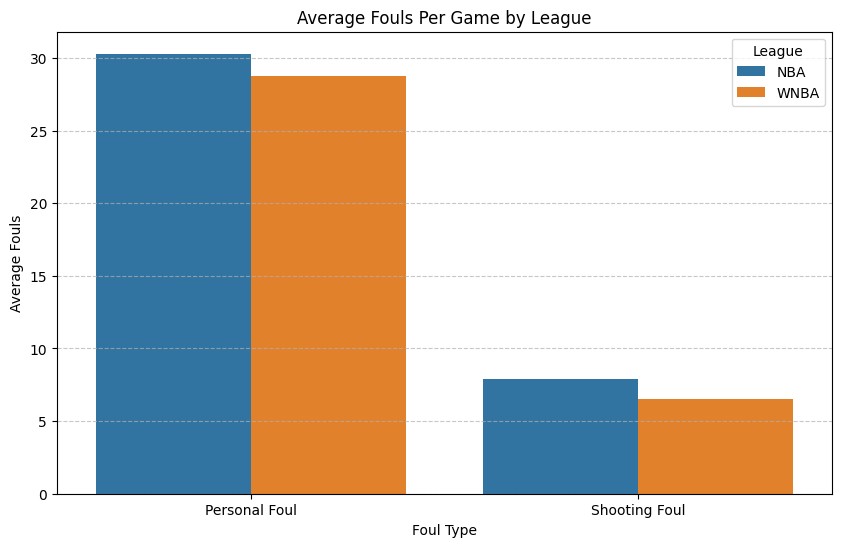

In [ ]:
fouls_with_rates_pd = fouls_with_rates.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=fouls_with_rates_pd,
            x='Foul Type',
            y='Fouls Per Game',
            hue='league')
plt.title('Average Fouls Per Game by League')
plt.xlabel('Foul Type')
plt.ylabel('Average Fouls')
plt.legend(title='League')
plt.grid(axis='y',
         linestyle='--',
         alpha=0.7)
plt.show()

In [ ]:
point_ratio_df = (combined_df
                  .filter(col("etype").isin("1", "2", "3"))
                  .filter(col("opt1").isin("1", "2", "3"))
                  .withColumn("made", when(col("etype") == "1", 1).otherwise(0))
                  .withColumn("value",col("opt1")))

point_ratio_df = (point_ratio_df
                  .groupBy("league")
                  .agg(
                      count("*").alias("shots"),
                      sum(when(col("value") == 1, 1)).alias("FTA"),
                      sum(when(col("value") == 2, 1)).alias("2PA"),
                      sum(when(col("value") == 3, 1)).alias("3PA"),
                      sum(when((col("value") == 2) & (col("made") == 1), 1)).alias("2PM"),
                      sum(when((col("value") == 3) & (col("made") == 1), 1)).alias("3PM"))

                  .withColumn("2P%", col("2PM") / col("2PA") * 100)
                  .withColumn("3P%", col("3PM") / col("3PA") * 100)
                  .withColumn("FT share", col("FTA") / col("shots") * 100)
                  .withColumn("2P share", col("2PA") / col("shots") * 100)
                  .withColumn("3P share", col("3PA") / col("shots") * 100)
                  .select("league", "FT share", "2P share", "3P share")
)

point_ratio_df.show()


+------+-----------------+------------------+------------------+
|league|         FT share|          2P share|          3P share|
+------+-----------------+------------------+------------------+
|   NBA|15.23750183257587|50.876337780384105| 33.88616038704002|
|  WNBA|16.41232433476602|57.118365770029456|26.469309895204518|
+------+-----------------+------------------+------------------+



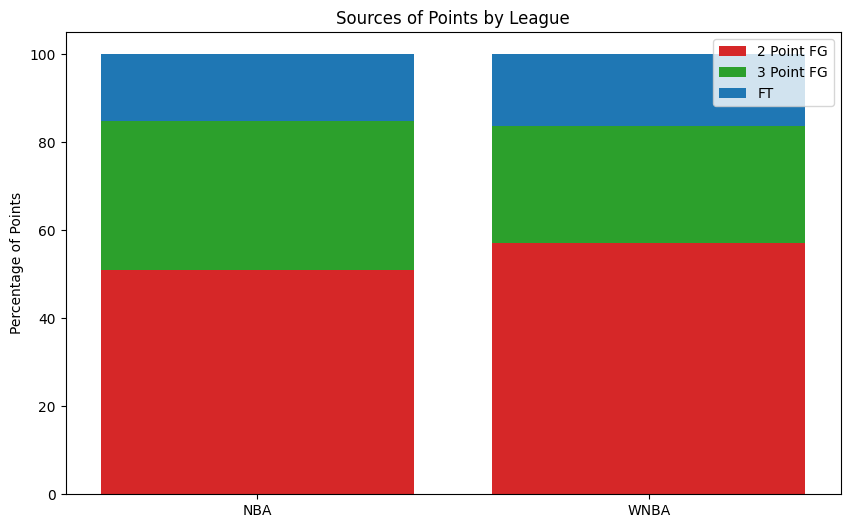

In [ ]:
point_ratio_pd = point_ratio_df.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(point_ratio_pd["league"],
        point_ratio_pd["2P share"],
        label="2 Point FG",
        color = "#d62728")
plt.bar(point_ratio_pd["league"],
        point_ratio_pd["3P share"],
        bottom=point_ratio_pd["2P share"],
        label="3 Point FG",
        color = '#2ca02c')
plt.bar(
    point_ratio_pd["league"],
    point_ratio_pd["FT share"],
    bottom=point_ratio_pd["3P share"] + point_ratio_pd["2P share"],
    label="FT",
    color="#1f77b4")
plt.ylabel("Percentage of Points")
plt.title("Sources of Points by League")
plt.legend()

plt.show()

In [ ]:
nba_2016 = (spark.read
           .option("header", "true")
           .csv("datanba_2016.csv"))
nba_2017 = (spark.read
           .option("header", "true")
           .csv("datanba_2017.csv"))
nba_2018 = (spark.read
           .option("header", "true")
           .csv("datanba_2018.csv"))
nba_2019 = (spark.read
           .option("header", "true")
           .csv("datanba_2019.csv"))
nba_2020 = (spark.read
           .option("header", "true")
           .csv("datanba_2020.csv"))
nba_2021 = (spark.read
           .option("header", "true")
           .csv("datanba_2021.csv"))
nba_2022 = (spark.read
           .option("header", "true")
           .csv("datanba_2022.csv"))
nba_2023 = (spark.read
           .option("header", "true")
           .csv("datanba_2023.csv"))
nba_2024 = (spark.read
           .option("header", "true")
           .csv("datanba_2024 (1).csv"))

nba_2016_y = nba_2016.withColumn("year", lit(2016))
nba_2017_y = nba_2017.withColumn("year", lit(2017))
nba_2018_y = nba_2018.withColumn("year", lit(2018))
nba_2019_y = nba_2019.withColumn("year", lit(2019))
nba_2020_y = nba_2020.withColumn("year", lit(2020))
nba_2021_y = nba_2021.withColumn("year", lit(2021))
nba_2022_y = nba_2022.withColumn("year", lit(2022))
nba_2023_y = nba_2023.withColumn("year", lit(2023))
nba_2024_y = nba_2024.withColumn("year", lit(2024))

from functools import reduce

dfs = [
    nba_2016_y,
    nba_2017_y,
    nba_2018_y,
    nba_2019_y,
    nba_2020_y,
    nba_2021_y,
    nba_2022_y,
    nba_2023_y,
    nba_2024_y
]

df_nba = reduce(
    lambda a, b: a.unionByName(b, allowMissingColumns=True),
    dfs
)
df_nba = (
    df_nba
    .select("year", "etype", "opt1", "locX", "locY", "de")  # only columns we actually use
    .repartition("year")                                   # partition data by year for later groupBy
)

df_nba.select("year").groupBy("year").count().show()




+----+------+
|year| count|
+----+------+
|2016|564696|
|2017|570288|
|2018|597818|
|2019|516086|
|2020|512581|
|2021|585713|
|2022|588564|
|2023|580476|
|2024|589747|
+----+------+



In [ ]:
from pyspark.sql.functions import col, when, sum as Fsum, count as Fcount

# Keep only field goal attempts: etype 1 = made FG, 2 = missed FG
# And only 2-point and 3-point shots based on opt1
shots = (
    df_nba
    .filter(col("etype").isin("1", "2", 1, 2))
    .filter(col("opt1").isin("2", "3"))
)

# 1 if made, 0 otherwise
shots = shots.withColumn(
    "made",
    when((col("etype") == 1) | (col("etype") == "1"), 1).otherwise(0)
)

# shot_value = 2 or 3
shots = shots.withColumn("shot_value", col("opt1").cast("int"))
shots = shots.cache()

shots.select("year", "etype", "opt1", "shot_value", "made").show(10)

yearly = (
    shots.groupBy("year")
         .agg(
             Fcount("*").alias("total_attempts"),
             Fsum("made").alias("total_made"),

             Fsum(when(col("shot_value") == 2, 1).otherwise(0)).alias("two_attempts"),
             Fsum(
                 when((col("shot_value") == 2) & (col("made") == 1), 1)
                 .otherwise(0)
             ).alias("two_made"),

             Fsum(when(col("shot_value") == 3, 1).otherwise(0)).alias("three_attempts"),
             Fsum(
                 when((col("shot_value") == 3) & (col("made") == 1), 1)
                 .otherwise(0)
             ).alias("three_made")
         )
)

yearly.show()



+----+-----+----+----------+----+
|year|etype|opt1|shot_value|made|
+----+-----+----+----------+----+
|2018|    2|   3|         3|   0|
|2018|    2|   3|         3|   0|
|2018|    2|   2|         2|   0|
|2018|    1|   2|         2|   1|
|2018|    2|   2|         2|   0|
|2018|    2|   3|         3|   0|
|2018|    2|   2|         2|   0|
|2018|    2|   2|         2|   0|
|2018|    2|   2|         2|   0|
|2018|    2|   2|         2|   0|
+----+-----+----+----------+----+
only showing top 10 rows

+----+--------------+----------+------------+--------+--------------+----------+
|year|total_attempts|total_made|two_attempts|two_made|three_attempts|three_made|
+----+--------------+----------+------------+--------+--------------+----------+
|2018|        219458|    101062|      140716|   73107|         78742|     27955|
|2023|        218134|    103467|      132001|   71980|         86133|     31487|
|2022|        217217|    103260|      133052|   72901|         84165|     30359|
|2019|      

In [ ]:
yearly_stats = (
    yearly
    .withColumn("fg_pct", 100.0 * col("total_made") / col("total_attempts"))
    .withColumn("two_pct", 100.0 * col("two_made") / col("two_attempts"))
    .withColumn("three_pct", 100.0 * col("three_made") / col("three_attempts"))
    .withColumn("three_attempt_rate", 100.0 * col("three_attempts") / col("total_attempts"))
    .orderBy("year")
)

yearly_stats.show()


+----+--------------+----------+------------+--------+--------------+----------+------------------+------------------+------------------+------------------+
|year|total_attempts|total_made|two_attempts|two_made|three_attempts|three_made|            fg_pct|           two_pct|         three_pct|three_attempt_rate|
+----+--------------+----------+------------+--------+--------------+----------+------------------+------------------+------------------+------------------+
|2016|        210110|     96061|      143692|   72313|         66418|     23748| 45.71938508400362| 50.32500069593297| 35.75536752085278|31.611060872876113|
|2017|        211706|     97435|      140367|   71628|         71339|     25807| 46.02373102321143| 51.02908803351215| 36.17516365522365| 33.69720272453308|
|2018|        219458|    101062|      140716|   73107|         78742|     27955|46.050724967875404|51.953580260951135|35.502019252749484|  35.8802139817186|
|2019|        187572|     86323|      115549|   60546|    

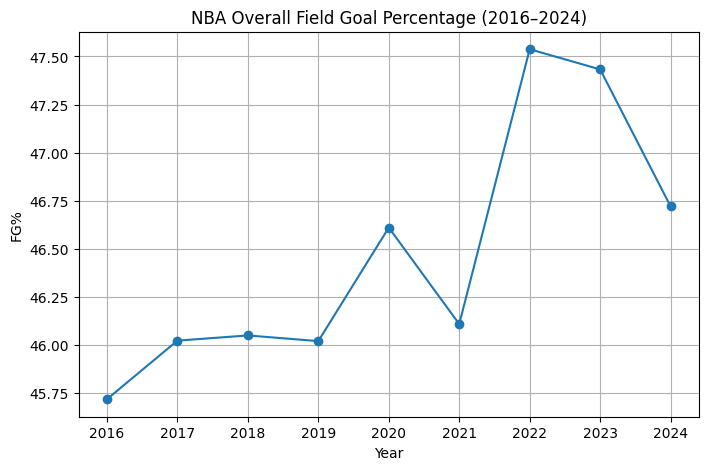

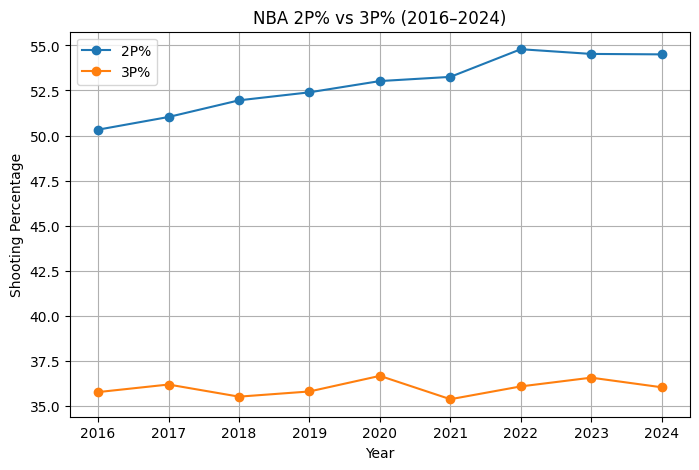

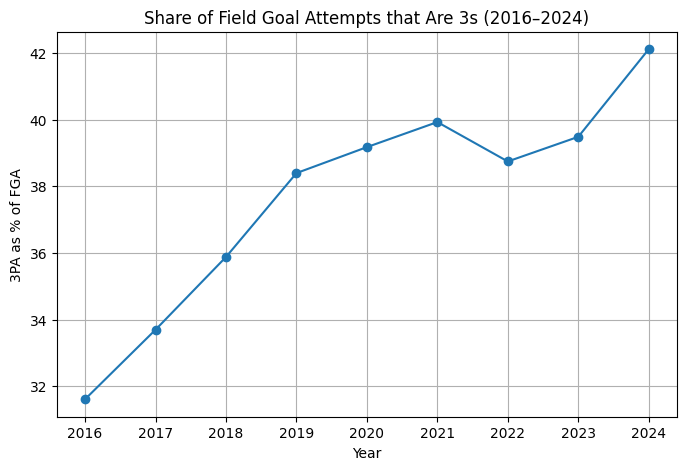

In [ ]:
yearly_pd = yearly_stats.toPandas()
yearly_pd

plt.figure(figsize=(8, 5))
plt.plot(yearly_pd["year"], yearly_pd["fg_pct"], marker="o")
plt.xlabel("Year")
plt.ylabel("FG%")
plt.title("NBA Overall Field Goal Percentage (2016–2024)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(yearly_pd["year"], yearly_pd["two_pct"], marker="o", label="2P%")
plt.plot(yearly_pd["year"], yearly_pd["three_pct"], marker="o", label="3P%")
plt.xlabel("Year")
plt.ylabel("Shooting Percentage")
plt.title("NBA 2P% vs 3P% (2016–2024)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(yearly_pd["year"], yearly_pd["three_attempt_rate"], marker="o")
plt.xlabel("Year")
plt.ylabel("3PA as % of FGA")
plt.title("Share of Field Goal Attempts that Are 3s (2016–2024)")
plt.grid(True)
plt.show()


Average Distance Over Years


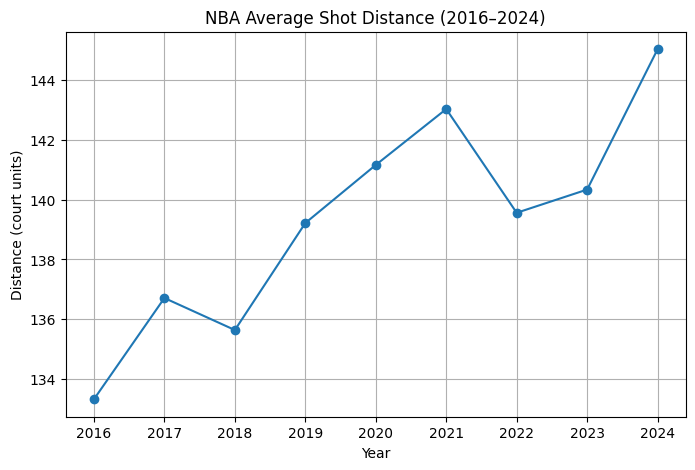

In [ ]:

# Start from FG attempts only (shots)
shots_dist = (
    shots
    .filter(col("locX").cast("double").isNotNull())
    .filter(col("locY").cast("double").isNotNull())
    # filter out insane coordinates / bad rows
    .filter((col("locX") > -300) & (col("locX") < 300))
    .filter((col("locY") > -100) & (col("locY") < 1100))
    .withColumn(
        "shot_distance",
        sqrt(pow(col("locX").cast("double"), 2) + pow(col("locY").cast("double"), 2))
    )
).cache()

avg_distance_by_year = (
    shots_dist.groupBy("year")
              .agg(avg("shot_distance").alias("avg_shot_distance"))
              .orderBy("year")
)

dist_pd = avg_distance_by_year.toPandas()
dist_pd
plt.figure(figsize=(8,5))
plt.plot(dist_pd["year"], dist_pd["avg_shot_distance"], marker="o")
plt.title("NBA Average Shot Distance (2016–2024)")
plt.xlabel("Year")
plt.ylabel("Distance (court units)")
plt.grid(True)
plt.show()


Free Throw

+----+---------------------------------------------+
|year|de                                           |
+----+---------------------------------------------+
|2018|[BOS 8-8] Tatum Free Throw 1 of 2 (6 PTS)    |
|2018|[BOS 9-8] Tatum Free Throw 2 of 2 (7 PTS)    |
|2018|[BOS] Brown Free Throw 1 of 2 Missed         |
|2018|[BOS 14-8] Brown Free Throw 2 of 2 (5 PTS)   |
|2018|[PHI] Johnson Free Throw 1 of 2 Missed       |
|2018|[PHI 11-14] Johnson Free Throw 2 of 2 (1 PTS)|
|2018|[BOS 19-11] Horford Free Throw 1 of 1 (3 PTS)|
|2018|[PHI] Simmons Free Throw 1 of 2 Missed       |
|2018|[PHI 15-21] Simmons Free Throw 2 of 2 (3 PTS)|
|2018|[BOS] Smart Free Throw 1 of 2 Missed         |
+----+---------------------------------------------+
only showing top 10 rows



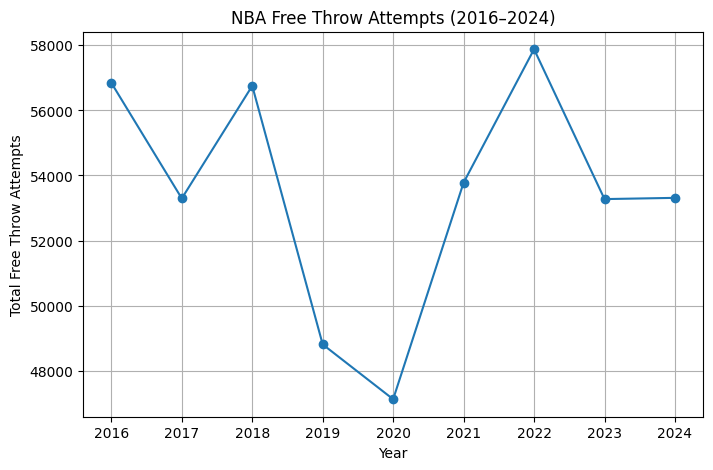

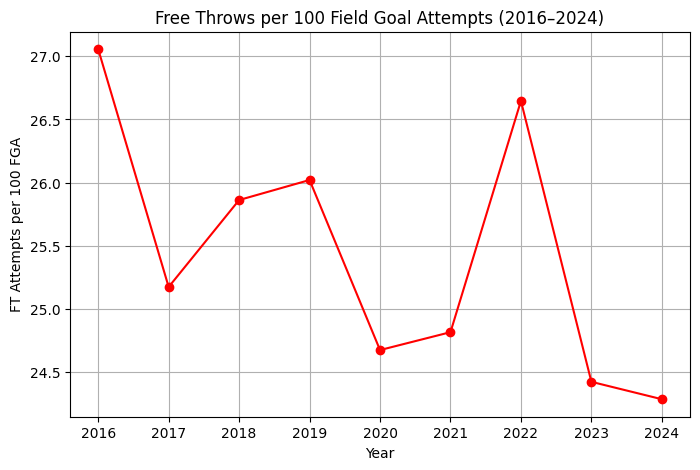

In [ ]:

# free throws = events whose description text mentions 'free throw'
fts = (
    df_nba
    .filter(col("de").isNotNull())
    .filter(lower(col("de")).like("%free throw%"))
)

fts.select("year", "de").show(10, truncate=False)
ft_by_year = (
    fts.groupBy("year")
       .agg(Fcount("*").alias("ft_attempts"))
       .orderBy("year")
)

ft_by_year_pd = ft_by_year.toPandas()
ft_by_year_pd

ft_rate = (
    ft_by_year.join(yearly.select("year", "total_attempts"), "year")
              .withColumn("ft_per_100_fga", 100.0 * col("ft_attempts") / col("total_attempts"))
              .orderBy("year")
)

ft_rate_pd = ft_rate.toPandas()
ft_rate_pd
plt.figure(figsize=(8,5))
plt.plot(ft_by_year_pd["year"], ft_by_year_pd["ft_attempts"], marker="o")
plt.title("NBA Free Throw Attempts (2016–2024)")
plt.xlabel("Year")
plt.ylabel("Total Free Throw Attempts")
plt.grid(True)
plt.show()
plt.figure(figsize=(8,5))
plt.plot(ft_rate_pd["year"], ft_rate_pd["ft_per_100_fga"], marker="o", color="red")
plt.title("Free Throws per 100 Field Goal Attempts (2016–2024)")
plt.xlabel("Year")
plt.ylabel("FT Attempts per 100 FGA")
plt.grid(True)
plt.show()


# 5. Performance Tuning

For performance tuning, we mainly focused on keeping Spark from doing unnecessary work. We cached the big combined DataFrame so repeated aggregations didn’t trigger full recomputations. We also filtered and selected only the columns we needed early on, which helped avoid scanning extra data. For small reference tables, we used broadcast joins so Spark didn’t shuffle the large DataFrame around. These changes kept everything running fast enough in Colab and made the group-bys and aggregations much smoother.

# 6. Results
Across all of the trends we looked at, the results pretty much lined up with what we expected about how the modern NBA plays compared to both its past and the WNBA. From 2016–2024, the NBA kept increasing its reliance on the three-point shot, with 3PA share climbing from around 31% to over 42%. Even though 3P% didn’t change much, 2P% steadily improved, which helped push overall FG% up. Average shot distance also drifted farther from the basket, which matches the league’s shift toward spacing and perimeter play. Free throws were basically flat overall, but there were small dips during the “no foul baiting” years around 2019–2021. When comparing the NBA to the WNBA, the NBA shoots a slightly better percentage at both 2s and 3s, and they take way more threes per game. Meanwhile, the WNBA gets a bigger share of its points from 2-pointers and relies less on free throws. We also found that the NBA commits slightly more personal and shooting fouls on average. Overall, the numbers show real stylistic differences between the two leagues and clear evolution in NBA offense over time.

# 7. Conclusion
Using Spark DataFrames honestly made this whole project way easier, because the dataset was way too big to load in normal pandas, and Spark let us run all the filtering and grouping across multiple years without running into memory issues. For what we were trying to do, Spark was definitely the right tool. If I were to change anything, I’d probably start with all the data from the beginning instead of testing smaller chunks first, just to be more organized from the start. With more time, I’d want to expand the analysis back to the late 90s and maybe look at player-level trends or team-specific evolutions instead of only league averages. But overall, the approach worked well, and the results gave a clear picture of how NBA and WNBA scoring styles compare and how the NBA has evolved over the past decade.